# Hand Gesture Recognition — ML Pipeline

This notebook builds a machine learning pipeline to classify **18 hand gestures** using 3D hand landmark coordinates extracted from images/video.

## Pipeline Overview

1. **Data Loading** — Load the hand landmark dataset  
2. **Feature Engineering** — Column inspection  
3. **Preprocessing** — Translation & scale normalization  
4. **Class Balancing** — SMOTE oversampling for minority classes  
5. **Label Encoding** — Convert gesture names to numeric labels  
6. **Train/Test Split** — 80/20 stratified split  
7. **SVM Hyperparameter Tuning** — GridSearchCV with 5-fold cross-validation  
8. **Model Training & Evaluation** — Random Forest, SVM, KNN comparison  
9. **Visualization** — Performance chart & confusion matrix  
10. **Model Persistence** — Save best model with joblib  
11. **Real-Time Inference** — Live webcam gesture recognition via MediaPipe  


## 1. Imports

Import all required libraries:
- **pandas / numpy** — data manipulation and numerical operations  
- **matplotlib / seaborn** — visualization  
- **scikit-learn** — classifiers, metrics, preprocessing, and model selection  
- **joblib** — model serialization  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder

import joblib

## 2. Load Dataset

Load the hand landmark CSV file.

The dataset contains **25,675 samples** across **64 columns**:
- 63 feature columns representing the **(x, y, z)** coordinates of **21 hand landmarks** (landmark 1–21)
- 1 target column: **`label`** (gesture name)

Each row is a single hand pose frame.


In [2]:
df = pd.read_csv('/Users/ahmedtarek/Developer/Python/ML1 Project/hand_landmarks_data.csv')
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (25675, 64)


,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,x19,y19,z19,x20,y20,z20,x21,y21,z21,label
0,262.669968,257.304901,-3.649205e-07,257.417542,247.109055,0.004224,246.882957,241.716827,0.005798,236.384537,...,223.345093,255.490692,-0.020450,215.043365,258.114746,-0.024577,208.006393,259.608673,-0.026722,call
1,83.351778,346.059113,-2.345265e-07,81.925037,328.562347,-0.011102,90.080132,311.535248,-0.021096,95.641823,...,132.451618,341.794434,-0.038175,142.773582,342.829254,-0.037336,152.431698,343.015991,-0.036136,call
2,187.756977,260.235492,-2.417307e-07,195.460579,241.506035,-0.000184,207.259529,223.674339,-0.009687,215.413628,...,250.301010,268.602938,-0.044068,262.425133,271.276638,-0.040469,272.989952,272.272231,-0.038301,call
3,114.976696,331.594238,-1.233261e-07,114.503494,320.549957,-0.002824,116.636627,310.080994,-0.008911,117.685066,...,145.195450,329.357544,-0.027622,151.053200,329.712341,-0.027863,155.990364,329.548828,-0.027723,call
4,188.795288,141.727867,-1.622995e-07,188.520905,127.947464,-0.002884,191.982880,111.010563,-0.008115,192.552521,...,226.696396,132.263248,-0.025113,234.831741,130.684147,-0.024087,241.587769,128.477188,-0.023486,call


## 3. Inspect Feature Columns

Print all column names to verify the structure:
- Columns `x1`–`z21` → 21 landmarks × 3 axes = **63 features**
- Column `label` → target class


In [3]:
print(df.columns)

Index(['x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4',
       'x5', 'y5', 'z5', 'x6', 'y6', 'z6', 'x7', 'y7', 'z7', 'x8', 'y8', 'z8',
       'x9', 'y9', 'z9', 'x10', 'y10', 'z10', 'x11', 'y11', 'z11', 'x12',
       'y12', 'z12', 'x13', 'y13', 'z13', 'x14', 'y14', 'z14', 'x15', 'y15',
       'z15', 'x16', 'y16', 'z16', 'x17', 'y17', 'z17', 'x18', 'y18', 'z18',
       'x19', 'y19', 'z19', 'x20', 'y20', 'z20', 'x21', 'y21', 'z21', 'label'],
      dtype='str')


## 4. Feature Normalization (Preprocessing)

Apply two normalization steps to make features **position- and scale-invariant**:

### Step 1 — Translation Normalization
Subtract the wrist landmark (landmark 0) coordinates from all X and Y values.  
This centers the hand at the origin, removing camera/position bias.

### Step 2 — Scale Normalization  
Compute the mean Euclidean distance from the wrist to the **4 fingertips** (indices 8, 12, 16, 20 — excluding the thumb).  
Divide all X and Y coordinates by this scale factor so that hand size differences don't affect classification.

> ⚠️ Z coordinates are **not** scaled.


In [5]:
X = df.drop('label', axis=1).copy()
y = df['label']

x_cols = list(range(0, X.shape[1], 3))
y_cols = [c + 1 for c in x_cols]
z_cols = [c + 2 for c in x_cols]

# 1️⃣ Translation normalization (X and Y only)
X.iloc[:, x_cols] = X.iloc[:, x_cols].sub(X.iloc[:, 0], axis=0)
X.iloc[:, y_cols] = X.iloc[:, y_cols].sub(X.iloc[:, 1], axis=0)

# 2️⃣ Scale normalization using 4 fingertips (no thumb)
fingertip_indices = [8, 12, 16, 20]

fingertip_distances = []
for tip in fingertip_indices:
    col_x = tip * 3
    col_y = tip * 3 + 1
    dist = np.sqrt(X.iloc[:, col_x]**2 + X.iloc[:, col_y]**2)
    fingertip_distances.append(dist)

div = np.mean(fingertip_distances, axis=0)
div = np.where(div < 1e-6, 1e-6, div)

X.iloc[:, x_cols] = X.iloc[:, x_cols].div(div, axis=0)
X.iloc[:, y_cols] = X.iloc[:, y_cols].div(div, axis=0)

## 5. Verify Feature Count

Confirm that after dropping the `label` column, there are exactly **63 feature columns** (21 landmarks × 3 axes).


In [6]:
print(X.shape[1])

63


## 6. Class Distribution Inspection

Print the label distribution to identify class imbalance before applying SMOTE.


In [7]:
print(y)

0                   call
1                   call
2                   call
3                   call
4                   call
              ...       
25670    two_up_inverted
25671    two_up_inverted
25672    two_up_inverted
25673    two_up_inverted
25674    two_up_inverted
Name: label, Length: 25675, dtype: str


## 7. Label Encoding

Convert string gesture labels into **integer class indices** using `LabelEncoder`.

Encodings are created:
- `y_encoded` — encoded labels for the original (non-resampled) data (used for train/test split)

The 18 gesture classes are printed in alphabetical order.


In [8]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Classes:", le.classes_)

Classes: ['call' 'dislike' 'fist' 'four' 'like' 'mute' 'ok' 'one' 'palm' 'peace'
 'peace_inverted' 'rock' 'stop' 'stop_inverted' 'three' 'three2' 'two_up'
 'two_up_inverted']


## 8. Train / Test Split

Split the **original (non-resampled)** dataset into training and testing sets:
- **80%** training, **20%** test  
- **Stratified** split to preserve class proportions  
- `random_state=42` for reproducibility


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

## 9. SVM Hyperparameter Tuning (GridSearchCV)

Perform exhaustive hyperparameter search for the SVM classifier using **5-fold cross-validation**.

**Search space:**
| Parameter | Values |
|-----------|--------|
| `C` | 50, 60, 70 ,80, 85 , 90, 100, 110, 120, 130, 140 , 150 |
| `gamma` | 0.005,0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5 |
| `kernel` | `rbf` |

**Total combinations:** 156 candidates × 5 folds = **780 fits**

**Best Parameters found:** `C=60`, `gamma=0.2`, `kernel=rbf`  
**Test Accuracy:** ~**99.649%**

The full per-class classification report is printed.


In [10]:
param_grid = {
    'C': [50, 60, 70 ,80, 85 , 90, 100, 110, 120, 130, 140 , 150],
    'gamma': [0.005,0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
    'kernel': ['rbf']
}
svc = SVC()
grid = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid.fit(X, y_encoded)

print("Best Parameters:", grid.best_params_)

# 6️⃣ Evaluate on test set
y_pred = grid.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

Fitting 5 folds for each of 156 candidates, totalling 780 fits
Best Parameters: {'C': 60, 'gamma': 0.2, 'kernel': 'rbf'}
Test Accuracy: 0.9964946445959104
                 precision    recall  f1-score   support

           call       1.00      0.99      1.00       301
        dislike       1.00      1.00      1.00       259
           fist       1.00      1.00      1.00       189
           four       1.00      1.00      1.00       327
           like       0.99      1.00      0.99       287
           mute       0.99      1.00      0.99       217
             ok       1.00      0.99      1.00       318
            one       1.00      0.98      0.99       253
           palm       0.99      1.00      1.00       330
          peace       1.00      1.00      1.00       288
 peace_inverted       1.00      1.00      1.00       299
           rock       1.00      1.00      1.00       292
           stop       0.98      0.99      0.99       296
  stop_inverted       1.00      1.00      1.00

## 10. Multi-Model Training & Evaluation

Train and evaluate three classifiers on the same train/test split:

| Model | Configuration |
|-------|--------------|
| **Random Forest** | 300 trees, balanced class weight, min 4 samples/split |
| **SVM** | RBF kernel, C=60, gamma=0.2 |
| **KNN** | 3 neighbors, distance-weighted |

For each model:
- Train on `X_train` / `y_train`
- Predict on both train and test sets
- Report **train accuracy**, **test accuracy**, and **overfit gap**
- Print full **per-class classification report**

### Results Summary

| Model | Train Acc | Test Acc | Overfit Gap |
|-------|-----------|----------|-------------|
| Random Forest | 99.99% | 97.94% | 2.05% |
| **SVM** | **99.56%** | **99.08%** | **0.47%** |
| KNN | 100.00% | 98.11% | 1.89% |

> **SVM achieves the best generalization** with the smallest overfit gap.


In [14]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=300, max_depth=None, class_weight='balanced', min_samples_split=4, random_state=42),
    "SVM": SVC(kernel="rbf", C = 60, gamma = 0.2, probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=3, weights="distance")
}

results = {}
results_full = {}

for name, model in models.items():
    model.fit(X_train, y_train)

    train_preds = model.predict(X_train)
    test_preds  = model.predict(X_test)

    train_acc = accuracy_score(y_train, train_preds)
    test_acc  = accuracy_score(y_test,  test_preds)

    report = classification_report(y_test, test_preds, target_names=le.classes_, output_dict=True)
    wa = report['weighted avg']

    results[name] = test_acc
    results_full[name] = {
        'train_acc': train_acc,
        'test_acc':  test_acc,
        'precision': wa['precision'],
        'recall':    wa['recall'],
        'f1':        wa['f1-score'],
        'preds':     test_preds
    }

    gap = train_acc - test_acc
    print(f'\n======================')
    print(f'{name}')
    print(f'  Train Accuracy : {train_acc:.4f}')
    print(f'  Test  Accuracy : {test_acc:.4f}')
    print(f'  Overfit Gap    : {gap:.4f}')
    print(classification_report(y_test, test_preds, target_names=le.classes_))


Random Forest
  Train Accuracy : 0.9999
  Test  Accuracy : 0.9794
  Overfit Gap    : 0.0205
                 precision    recall  f1-score   support

           call       0.98      0.99      0.99       301
        dislike       1.00      1.00      1.00       259
           fist       1.00      0.99      1.00       189
           four       0.98      0.98      0.98       327
           like       0.99      0.99      0.99       287
           mute       0.95      0.97      0.96       217
             ok       0.99      0.99      0.99       318
            one       0.96      0.97      0.97       253
           palm       0.99      0.99      0.99       330
          peace       0.96      0.94      0.95       288
 peace_inverted       0.98      0.96      0.97       299
           rock       1.00      1.00      1.00       292
           stop       0.94      0.98      0.96       296
  stop_inverted       0.98      0.99      0.99       314
          three       1.00      0.97      0.98     

## 11. Performance Visualization & Overfit Check

**Bar Chart** — Compare Accuracy, Precision, Recall, and F1-Score across all three models side-by-side.

**Overfit Summary Table** — Print train accuracy, test accuracy, and the gap for each model to identify potential overfitting.


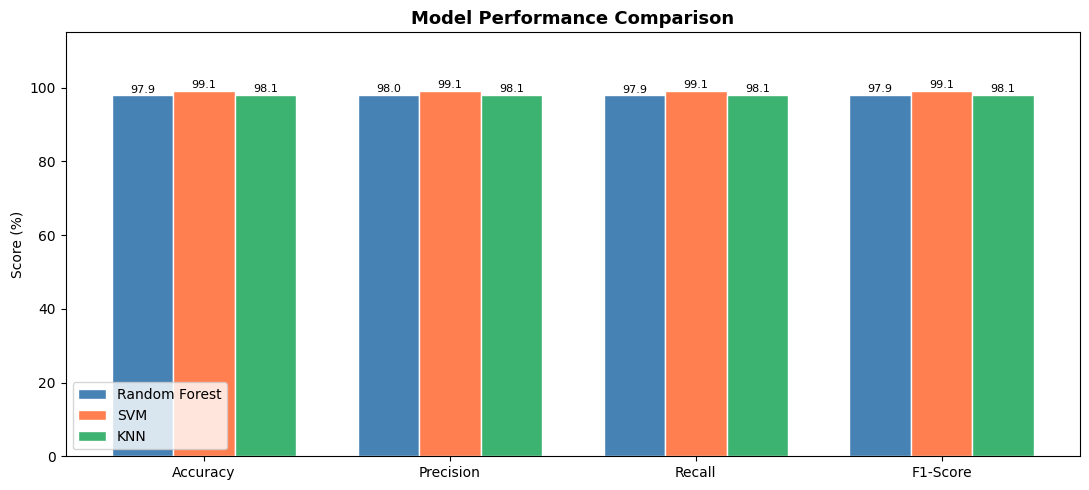


=== Overfit Check ===
Model                 Train Acc   Test Acc      Gap
----------------------------------------------------
Random Forest            99.99%     97.94%    2.05%
SVM                      99.56%     99.08%    0.47%
KNN                     100.00%     98.11%    1.89%


In [15]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
model_names = list(results_full.keys())
x = np.arange(len(metrics))
width = 0.25
colors = ['steelblue', 'coral', 'mediumseagreen']

fig, ax = plt.subplots(figsize=(11, 5))
for idx, (name, color) in enumerate(zip(model_names, colors)):
    r = results_full[name]
    vals = [r['test_acc'], r['precision'], r['recall'], r['f1']]
    bars = ax.bar(x + idx * width, [v * 100 for v in vals],
                  width, label=name, color=color, edgecolor='white')
    for bar, val in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2,
                f'{val*100:.1f}', ha='center', va='bottom', fontsize=8)

ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 115)
ax.set_title('Model Performance Comparison', fontsize=13, fontweight='bold')
ax.set_ylabel('Score (%)')
ax.legend()
plt.tight_layout()
plt.show()

# Overfit summary table
print('\n=== Overfit Check ===')
print(f'{"Model":<20} {"Train Acc":>10} {"Test Acc":>10} {"Gap":>8}')
print('-' * 52)
for name, r in results_full.items():
    gap = r['train_acc'] - r['test_acc']
    print(f'{name:<20} {r["train_acc"]*100:>9.2f}% {r["test_acc"]*100:>9.2f}% {gap*100:>7.2f}%')


## 12. Confusion Matrix for Best Model

Identify the **best-performing model** (highest test accuracy → SVM).

Generate and display a **heatmap confusion matrix** showing predicted vs actual gesture labels for the test set.

This reveals which gestures, if any, the model confuses with one another.


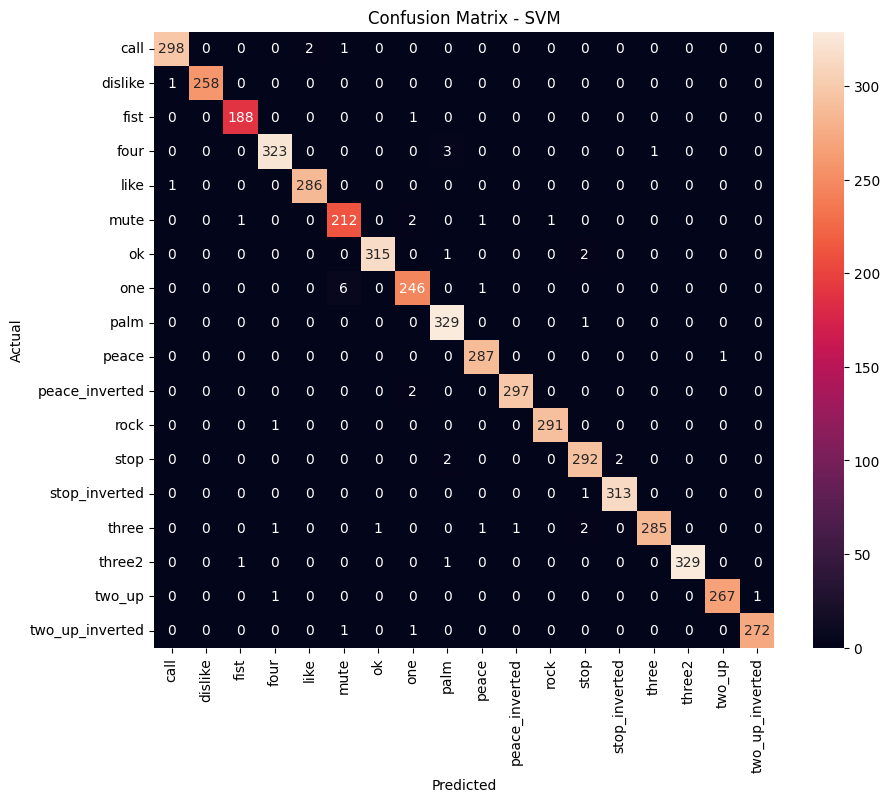

Best Model: SVM


In [16]:
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

preds = best_model.predict(X_test)

cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()

print("Best Model:", best_model_name)

## 13. Save Best Model

Serialize the best model and label encoder to disk using **joblib**:
- `best_gesture_model.pkl` — trained SVM classifier  
- `label_encoder.pkl` — fitted `LabelEncoder` to decode predictions back to gesture names


In [ ]:
joblib.dump(best_model, "best_gesture_model.pkl")
joblib.dump(le, "label_encoder.pkl")

print("Model saved successfully.")

Model saved successfully.


---

## Part 2: Real-Time Inference

The cells below implement **live webcam-based gesture recognition** using the saved model and MediaPipe hand tracking.


## 14. Real-Time Imports

Import additional libraries needed for real-time inference:
- **cv2 (OpenCV)** — webcam capture and frame display  
- **mediapipe** — real-time hand landmark detection  
- **deque / Counter** — sliding window buffer for stable predictions  


In [ ]:
import cv2
import mediapipe as mp
import numpy as np
from collections import deque, Counter
import joblib

## 15. Load Saved Model & Encoder

Reload the best model and label encoder from disk for inference.


In [ ]:
best_model = joblib.load("best_gesture_model.pkl")
le = joblib.load("label_encoder.pkl")

## 16. Load Training Feature Columns

Reload the training CSV to extract the **exact feature column order**.  
This ensures the live inference DataFrame matches the feature layout the model was trained on.


In [ ]:
import pandas as pd

# Load the CSV used for training
train_df = pd.read_csv('/Users/ahmedtarek/Developer/Python/ML1 Project/hand_landmarks_data.csv')

trained_feature_columns = [col for col in train_df.columns if col != 'label']

In [ ]:
# MediaPipe setup
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils

hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=1,
    min_detection_confidence=0.7,
    min_tracking_confidence=0.7
)

window_size = 20
prediction_buffer = deque(maxlen=window_size)

def normalize_landmarks(hand_landmarks):
    coords = np.array([[lm.x, lm.y, lm.z]
                       for lm in hand_landmarks.landmark], dtype=np.float32)

    # 1️⃣ Translation (X and Y only)
    wrist = coords[0].copy()
    coords[:, 0] -= wrist[0]  # X
    coords[:, 1] -= wrist[1]  # Y

    # 2️⃣ Scale using 4 fingertips (no thumb), 2D only
    fingertip_indices = [8, 12, 16, 20]
    fingertip_distances = np.linalg.norm(coords[fingertip_indices][:, :2], axis=1)
    scale = np.mean(fingertip_distances)

    if scale < 1e-6:
        scale = 1e-6

    coords[:, 0] /= scale  # X
    coords[:, 1] /= scale  # Y

    return coords.flatten() 

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise RuntimeError('Cannot open camera')

try:
    while True:
        success, frame = cap.read()
        if not success:
            break

        frame = cv2.flip(frame, 1)
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(rgb)

        display_text = 'No hand'

        if results.multi_hand_landmarks:
            hand_landmarks = results.multi_hand_landmarks[0]
            mp_draw.draw_landmarks(
                frame, 
                hand_landmarks, 
                mp_hands.HAND_CONNECTIONS
            )

            landmarks = normalize_landmarks(hand_landmarks)
            landmarks_df = pd.DataFrame([landmarks], columns=trained_feature_columns)
            encoded_pred = best_model.predict(landmarks_df)[0]
            gesture_name = le.inverse_transform([encoded_pred])[0]

            prediction_buffer.append(gesture_name)

            if len(prediction_buffer) == window_size:
                display_text = Counter(prediction_buffer).most_common(1)[0][0]
            else:
                display_text = "Stabilizing..."

        else:
            prediction_buffer.clear()

        cv2.putText(
            frame, 
            display_text, 
            (10, 40),
            cv2.FONT_HERSHEY_SIMPLEX, 
            1, 
            (0, 255, 0), 
            2
        )

        cv2.imshow("Hand Gesture Recognition", frame)

        if cv2.waitKey(1) & 0xFF == 27:  # Press ESC to quit
            break
        
except KeyboardInterrupt:
    print('Stopped.')

finally:
    cap.release()
    hands.close()
    cv2.destroyAllWindows()
    for _ in range(5):
        cv2.waitKey(1)
        
    print('Camera released.')

I0000 00:00:1772146098.294177       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M1 Pro


Camera released.
